# Part I : Load and Overview Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

## Load the data

In [2]:
wine = datasets.load_wine()

In [3]:
n_samples, n_features = wine['data'].shape

In [4]:
n_targets = wine['target_names'].shape[0]

In [5]:
target_names = wine['target_names']

In [6]:
X = wine['data']
y = wine['target']

## Number of samples/instances

In [7]:
print(f"Number of samples in the wine dataset : {n_samples}")

Number of samples in the wine dataset : 178


## Number of dimensions/features/attributes

In [8]:
print(f"Number of features in the wine dataset : {n_features}")

Number of features in the wine dataset : 13


## Number of classes

In [9]:
print(f"Number of classes in the wine dataset : {n_targets}")

Number of classes in the wine dataset : 3


## Names of classes

In [10]:
print(f"Names of classes in the wine dataset : {', '.join(target_names)}")

Names of classes in the wine dataset : class_0, class_1, class_2


## Number of samples per class

In [11]:
targets, target_counts = np.unique(y, return_counts=True)
per_target_counts = dict(zip(targets, target_counts))

In [12]:
print(f"Number of samples per class : ")
for target, count in per_target_counts.items():
    print(f"class {target} : {count}")

Number of samples per class : 
class 0 : 59
class 1 : 71
class 2 : 48


# Part II : Clustering

**Clustering Methods used:**
1. KMeans
2. Agglomerative Clustering
3. DBSCAN[\[2\]](#reference_2)[\[3\]](#reference_3)
4. Gaussian Mixture Model
5. Affinity Propagation[\[4\]](#reference_4)
6. BIRCH[\[5\]](#reference_5)




In [13]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

def internal_evaluation(X, labels):
    print("\nINTERNAL EVALUATION : ")
    print(f"A. Silhouette score (-1 to 1, ideally should be 1) : {np.round(silhouette_score(X, labels),2)}")
    print(f"B. Calinski-Harabasz score (ideally should be higher) : {np.round(calinski_harabasz_score(X, labels),2)}")
    print(f"C. Davies-Bouldin score (ideally should be 0) : {np.round(davies_bouldin_score(X, labels),2)}")

In [14]:
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score

def external_evaluation(labels_true, labels_pred):
    print("\nEXTERNAL EVALUATION : ")
    print(f"A. V measure score (0 to 1, ideally should be 1) : {np.round(v_measure_score(labels_true, labels_pred),2)}")
    print(f"B. Adjusted rand index score (0 to 1, ideally should be 1) : {np.round(adjusted_rand_score(labels_true, labels_pred),2)}")

## Method I - KMeans

### Training

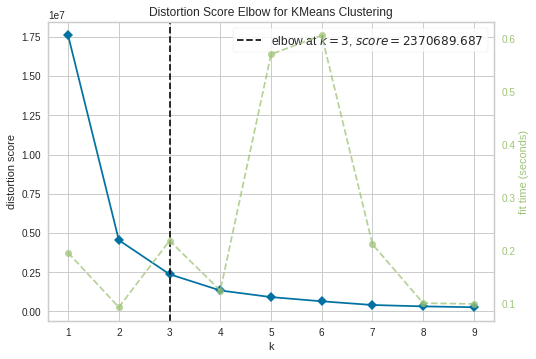

In [15]:
# Elbow method visualisation for KMeans

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(n_init=10, random_state = 42)
visualizer = KElbowVisualizer(kmeans, k=(1,10)) # K values from 1 to 10
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

From the Elbow method analysis, K=3 seems like a good choice for number of clusters. However, K=4 is also a probable option and it is not exactly clear. Hence, we will analyse the Silhouette Scores as well for K = 2, 3, 4 and 5.

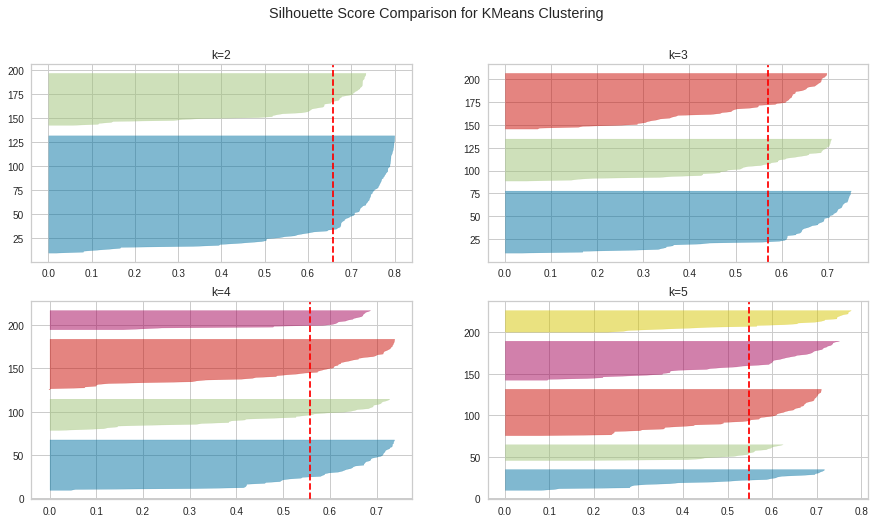

In [16]:
# Silhouette Score comparison for KMeans

from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))

for number_of_clusters in range(2, 6): 
    kmeans = KMeans(n_clusters = number_of_clusters, n_init=10, random_state = 42)
    q, mod = divmod(number_of_clusters, 2)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
ax[0,0].set_title('k=2')
ax[0,1].set_title('k=3')
ax[1,0].set_title('k=4')
ax[1,1].set_title('k=5')
fig.suptitle('Silhouette Score Comparison for KMeans Clustering')
plt.show()

After analysing the above plots, K = 2 is rejected as the width of clusters is marginally significant. Similarly, K = 4 and K = 5 can be rejected. K = 3 has good Silhouette Scores (more than the average i.e represented by red dotted line) and all the clusters don't vary much in width.

We conclude **K=3** as the ideal choice for number of clusters for wine dataset. [\[1\]](#reference_1)

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [18]:
# Scale the datapoints using StandartScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Reduce dimensionality using PCA on the scaled features
pca = PCA(n_components=.90)
X_pca = pca.fit(X_scaled).transform(X_scaled)
print("Number of features before PCA: ", str(len(wine.feature_names)))
print("Number of features after PCA: ", str(pca.n_components_))
print("Explained variance ratio: ", sum(pca.explained_variance_ratio_))

Number of features before PCA:  13
Number of features after PCA:  8
Explained variance ratio:  0.9201754434577263


In [20]:
# TRAINING

kmeans = KMeans(n_clusters=3, random_state=42)
# Fit the scaled features to KMeans Algorithm
kmeans_fit = kmeans.fit(X_scaled)

In [21]:
# Fit k-means on the post PCA data
kmeans_pca = kmeans.fit(X_pca)

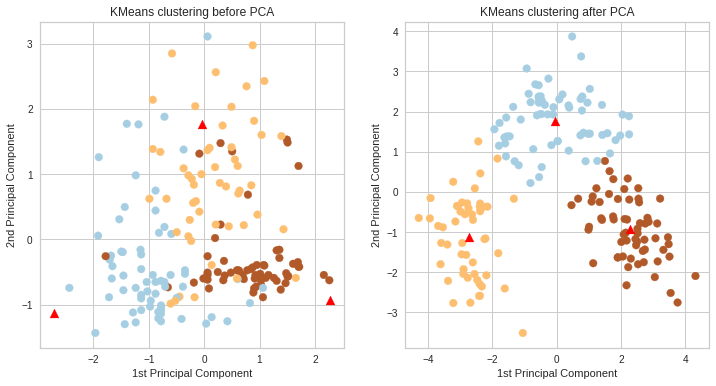

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Plotting datapoints
ax1.scatter(X_scaled[:,0], X_scaled[:,1], s=60 ,c=kmeans_fit.labels_, label = kmeans.labels_, cmap="Paired")
# Plotting centroids
ax1.scatter(kmeans_fit.cluster_centers_[:,0], kmeans_fit.cluster_centers_[:,1], color='red', s=80,label='Centroids', marker='^', cmap="Paired")
ax1.set_title('KMeans clustering before PCA')
ax1.set_xlabel('1st Principal Component')
ax1.set_ylabel('2nd Principal Component')

ax2.scatter(X_pca[:,0], X_pca[:,1], s=60 , c=kmeans_pca.labels_, label = kmeans_pca.labels_, cmap="Paired")

ax2.scatter(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1], color='red', s=80, label='Centroids', marker='^', cmap="Paired")
ax2.set_title('KMeans clustering after PCA')
ax2.set_xlabel('1st Principal Component')
ax2.set_ylabel('2nd Principal Component')

plt.show()

### Evaluation

In [23]:
# EVALUATION

print('KMeans Evaluation before PCA:')
internal_evaluation(X_scaled, kmeans_fit.labels_)
external_evaluation(y, kmeans_fit.labels_)

KMeans Evaluation before PCA:

INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.28
B. Calinski-Harabasz score (ideally should be higher) : 70.94
C. Davies-Bouldin score (ideally should be 0) : 1.39

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.88
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.9


In [24]:
print('\nKMeans Evaluation after PCA: ')
internal_evaluation(X_pca, kmeans_pca.labels_)
external_evaluation(y, kmeans_pca.labels_)


KMeans Evaluation after PCA: 

INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.31
B. Calinski-Harabasz score (ideally should be higher) : 82.75
C. Davies-Bouldin score (ideally should be 0) : 1.27

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.88
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.9


## Method II - Agglomerative Clustering

### Training

In [25]:
# TRAINING

from sklearn.cluster import AgglomerativeClustering

agglo_clustering = AgglomerativeClustering(n_clusters=3)
y_agglo = agglo_clustering.fit(X_pca)

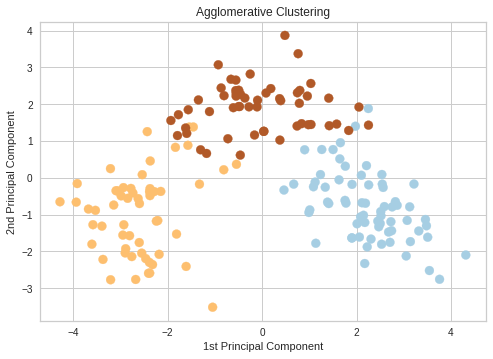

In [26]:
plt.scatter(X_pca[:,0],X_pca[:,1],s=80,c= y_agglo.labels_, cmap="Paired")
plt.title('Agglomerative Clustering')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

### Evaluation

In [27]:
# EVALUATION

internal_evaluation(X_pca, y_agglo.labels_)
external_evaluation(y, y_agglo.labels_)


INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.3
B. Calinski-Harabasz score (ideally should be higher) : 79.85
C. Davies-Bouldin score (ideally should be 0) : 1.26

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.75
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.74


## Method III - DBSCAN

### Training

Density-Based Spatial Clustering of Applications with Noise -  The algorithm finds core samples and tries to make clusters around the core samples.[\[2\]](#reference_2).



'eps' - Maximum distance between samples to consider they are in neighbourhood of each other.[\[3\]](#reference_3)

In [28]:
# TRAINING

from sklearn.cluster import DBSCAN

#eps=2 is the ideal value to get 3 clusters for this dataset
dbscan = DBSCAN(eps=2)
dbscan_fit = dbscan.fit_predict(X_pca)

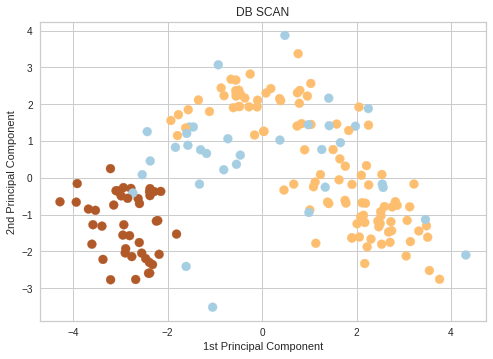

In [29]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=dbscan_fit,s=80, cmap="Paired")
plt.title('DB SCAN')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

### Evaluation

In [30]:
# EVALUATION

internal_evaluation(X_pca,dbscan_fit )
external_evaluation(y,dbscan_fit)


INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.23
B. Calinski-Harabasz score (ideally should be higher) : 35.94
C. Davies-Bouldin score (ideally should be 0) : 3.34

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.54
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.42


## Method IV - Gaussian Mixture Model

### Training

In [31]:
# TRAINING

from sklearn.mixture import GaussianMixture

#GMM model with 'tied' covariance type
gmm_tied = GaussianMixture(n_components=3,covariance_type='tied')
#GMM model with 'full' covariance type
gmm_full = GaussianMixture(n_components=3,covariance_type='full')

In [32]:
gmm_tied_fit = gmm_tied.fit_predict(X_pca)
gmm_full_fit = gmm_full.fit_predict(X_pca)

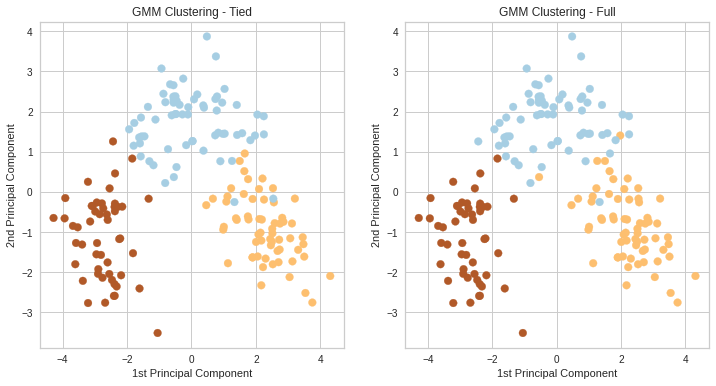

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#plotting datapoints
ax1.scatter(X_pca[:,0],X_pca[:,1], s=60 , c=gmm_tied_fit, cmap="Paired")
ax1.set_title('GMM Clustering - Tied')
ax1.set_xlabel('1st Principal Component')
ax1.set_ylabel('2nd Principal Component')

ax2.scatter(X_pca[:,0], X_pca[:,1], s=60 , c=gmm_full_fit, cmap="Paired")
ax2.set_title('GMM Clustering - Full')
ax2.set_xlabel('1st Principal Component')
ax2.set_ylabel('2nd Principal Component')

plt.show()

### Evaluation

In [34]:
# EVALUATION

print("Evaluation of GMM Tied model :")
internal_evaluation(X_pca,gmm_tied_fit )
external_evaluation(y,gmm_tied_fit)

Evaluation of GMM Tied model :

INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.31
B. Calinski-Harabasz score (ideally should be higher) : 81.47
C. Davies-Bouldin score (ideally should be 0) : 1.28

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.89
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.91


In [35]:
print("Evaluation of GMM Full model :")
internal_evaluation(X_pca,gmm_full_fit )
external_evaluation(y,gmm_full_fit)

Evaluation of GMM Full model :

INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.31
B. Calinski-Harabasz score (ideally should be higher) : 81.14
C. Davies-Bouldin score (ideally should be 0) : 1.28

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.86
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.88


## Method V - Affinity Propagation

### Training

Affinity Propogation creates clusters by sending messages between different pairs of samples until they are converged fully. The algorithm finds the number of clusters based on the dataset.[\[4\]](#reference_4)

In [36]:
# TRAINING

from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-150, random_state=42)
af.fit(X_pca)

AffinityPropagation(preference=-150, random_state=42)

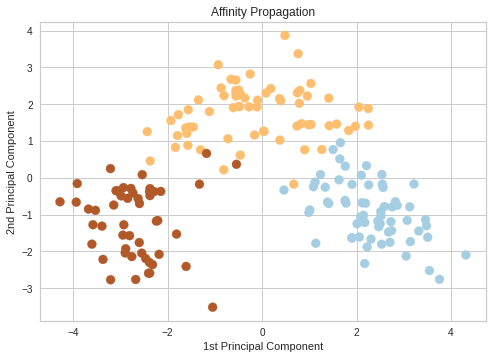

In [37]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=af.labels_,s=80,cmap="Paired")
plt.title('Affinity Propagation')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

### Evaluation

In [38]:
# EVALUATION

internal_evaluation(X_pca, af.labels_)
external_evaluation(y, af.labels_)


INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.31
B. Calinski-Harabasz score (ideally should be higher) : 80.32
C. Davies-Bouldin score (ideally should be 0) : 1.27

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.81
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.85


## Method VI - BIRCH

BIRCH builds a tree from the dataset called Clustering Feature Tree. It has 2 important parameters :
"threshold" - minimizes the distance between a sample and existing subclusters.
"branching factor" - minimizes number of subclusters in a node.[\[5\]](#reference_5)

### Training

In [39]:
# TRAINING

from sklearn.cluster import Birch

brc = Birch(n_clusters=3, threshold=0.9)
brc.fit(X_pca)

Birch(threshold=0.9)

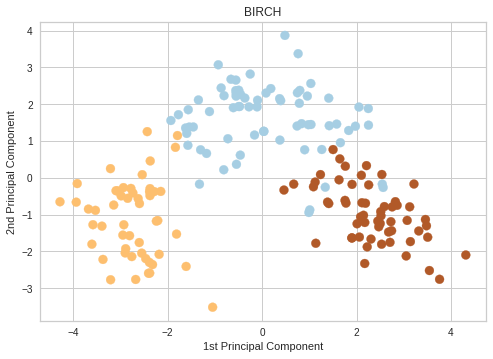

In [40]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=brc.labels_,s=80, cmap="Paired")
plt.title('BIRCH')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

### Evaluation

In [41]:
# EVALUATION

internal_evaluation(X_pca, brc.labels_)
external_evaluation(y, brc.labels_)


INTERNAL EVALUATION : 
A. Silhouette score (-1 to 1, ideally should be 1) : 0.31
B. Calinski-Harabasz score (ideally should be higher) : 79.09
C. Davies-Bouldin score (ideally should be 0) : 1.3

EXTERNAL EVALUATION : 
A. V measure score (0 to 1, ideally should be 1) : 0.85
B. Adjusted rand index score (0 to 1, ideally should be 1) : 0.88


# Part III : Classification

**Classification methods used:**

1. SVM
2. Decision Trees
3. KNN
4. Gradient Boost [\[7\]](#reference_7)[\[9\]](#reference_9)
5. Random Forest
6. AdaBoost


In [42]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

def classification_evaluation(y_true, y_pred, y_pred_prob):
    print(f"\nBalanced accuracy score (0 to 1, ideally should be 1) : {np.round(balanced_accuracy_score(y_true, y_pred),2)}")
    print(f"Precision score (0 to 1, ideally should be 1) : {np.round(precision_score(y_true, y_pred, average='micro'),2)}")
    print(f"Recall score (0 to 1, ideally should be 1) : {np.round(recall_score(y_true, y_pred, average='micro'),2)}")
    print(f"F1 score (0 to 1, ideally should be 1) : {np.round(f1_score(y_true, y_pred, average='micro'),2)}")
    print(f"ROC AUC score (0 to 1, ideally should be 1) : {np.round(roc_auc_score(y_true, y_pred_prob, multi_class='ovr'),2)}")
    print("\n")

def display_confusion_matrix(clf, X_test, y_test, class_names):
    disp = ConfusionMatrixDisplay.from_estimator(clf, 
                                                 X_test, 
                                                 y_test, 
                                                 display_labels=class_names, 
                                                 cmap=plt.cm.Blues,
                                                 normalize=None)
    plt.grid(False)
    plt.show()

In [43]:
from sklearn.model_selection import GridSearchCV

def gridSearch(classifier, param_grid, X_train, y_train):
    grid_search = GridSearchCV(classifier, param_grid)
    grid_search_fit = grid_search.fit(X_train, y_train)
    print("Best parameters for the model: ", grid_search_fit.best_params_)
    print("Best Score for the choosen parameters of the model: ", np.round(grid_search_fit.best_score_,2))
    return grid_search_fit.best_estimator_

## Split Data Protocol

Split the data into training (67%) and testing (33%).

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

### Method I - SVM

SVM uses a subset of training points in the decision function called support vectors. It provides common Kernel functions and supports custom kernels.

#### Training

In [45]:
# TRAINING

from sklearn import svm

clf_svm = svm.SVC(kernel="rbf", probability=True)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
y_pred_prob = clf_svm.predict_proba(X_test)

In [46]:
param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"],"degree":[2,3,4],"gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}
]
clf_svm_best = gridSearch(svm.SVC(probability=True),param_grid,X_train,y_train)

Best parameters for the model:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score for the choosen parameters of the model:  0.97


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.98
Precision score (0 to 1, ideally should be 1) : 0.98
Recall score (0 to 1, ideally should be 1) : 0.98
F1 score (0 to 1, ideally should be 1) : 0.98
ROC AUC score (0 to 1, ideally should be 1) : 1.0




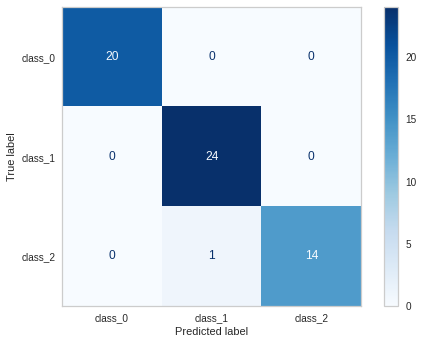

In [47]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(clf_svm, X_test, y_test, target_names)

SVM with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 1.0




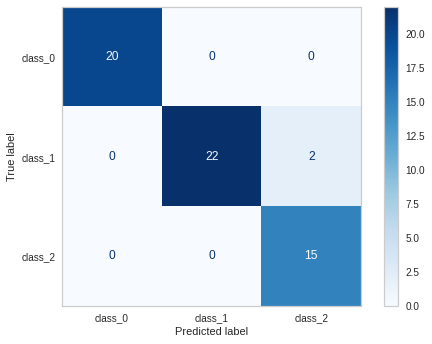

In [48]:
print('SVM with best fit parameters')
classification_evaluation(y_test, clf_svm_best.predict(X_test), clf_svm_best.predict_proba(X_test))
display_confusion_matrix(clf_svm_best, X_test, y_test, target_names)

### Method II - Decision Trees

Decision Trees predicts the target variable by learning decision rules from features, these can be visualised in form of a tree.

#### Training

In [49]:
# TRAINING

import graphviz
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0) 
tree.fit(X_train, y_train) 
y_pred_prob = tree.predict_proba(X_test)
y_pred = tree.predict(X_test)

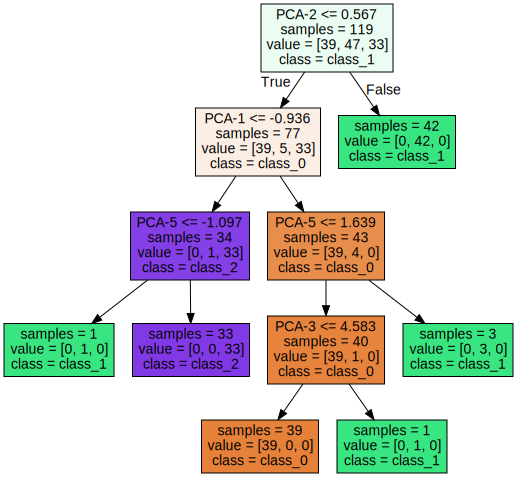

In [50]:
# Visualising the Decision Tree

from sklearn.tree import export_graphviz
export_graphviz(tree, 
                out_file="tree.dot", 
                class_names=["class_0", "class_1", "class_2"], 
                feature_names= ['PCA-1', 'PCA-2', 'PCA-3', 'PCA-4', 'PCA-5', 'PCA-6', 'PCA-7', 'PCA-8'], 
                impurity=False, filled=True)
with open("tree.dot") as f: 
  dot_graph = f.read() 
display(graphviz.Source(dot_graph))

In [51]:
param_grid = [
    {'max_depth': [2, 4, 6, 8],'criterion': ['gini', 'entropy'],'min_samples_split': [2, 4, 6, 8],'splitter':['best','random']}
]
tree_best = gridSearch(DecisionTreeClassifier(),param_grid,X_train,y_train)

Best parameters for the model:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Score for the choosen parameters of the model:  0.95


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 0.98




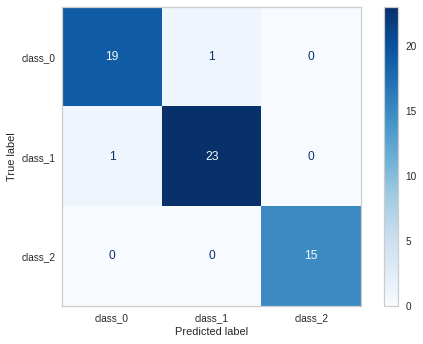

In [52]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(tree, X_test, y_test, target_names)

Decision Trees with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 0.98




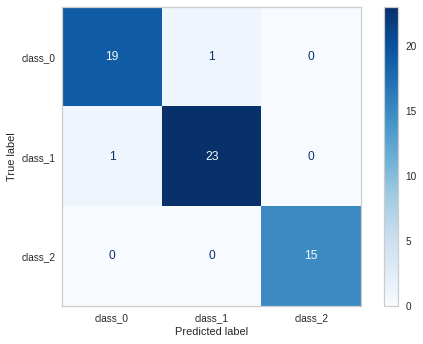

In [53]:
print('Decision Trees with best fit parameters')
classification_evaluation(y_test, tree_best.predict(X_test), tree_best.predict_proba(X_test))
display_confusion_matrix(tree_best, X_test, y_test, target_names)

### Method III - KNN

KNN maps the training samples (pre-defined) which are close to the new point and accordingly predict their label.


#### Training

In [54]:
# TRAINING

from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred_prob = knn.predict_proba(X_test)
y_pred = knn.predict(X_test)

In [55]:
param_grid = [
    {'n_neighbors': [3, 5, 7],'weights': ['uniform', 'distance'],'metric':['euclidean','manhattan'],'algorithm': ['auto','ball_tree','kd_tree','brute']}
]
knn_best = gridSearch(KNeighborsClassifier(),param_grid,X_train,y_train)

Best parameters for the model:  {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Score for the choosen parameters of the model:  0.95


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 0.98




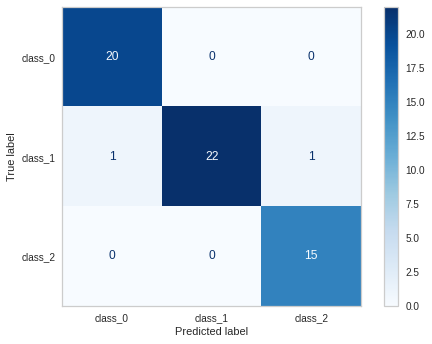

In [56]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(knn, X_test, y_test, target_names)

KNN with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.99
Precision score (0 to 1, ideally should be 1) : 0.98
Recall score (0 to 1, ideally should be 1) : 0.98
F1 score (0 to 1, ideally should be 1) : 0.98
ROC AUC score (0 to 1, ideally should be 1) : 1.0




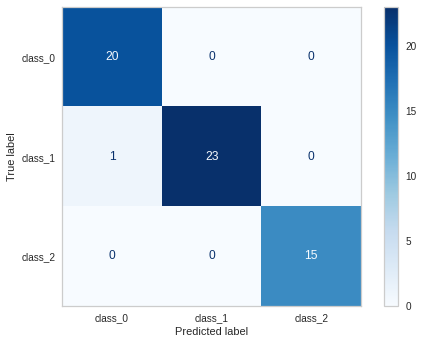

In [57]:
print('KNN with best fit parameters')
classification_evaluation(y_test, knn_best.predict(X_test), knn_best.predict_proba(X_test))
display_confusion_matrix(knn_best, X_test, y_test, target_names)

### Method IV - Gradient Boost

Gradient boost combines simple tree models and combines them iteratively for an improved performance.[\[7\]](#reference_7)

#### Training

In [58]:
# TRAINING

from sklearn.ensemble import GradientBoostingClassifier 
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(X_train, y_train) 
y_pred_prob = gbrt.predict_proba(X_test)
y_pred = gbrt.predict(X_test)

In [59]:
param_grid = [{'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [50, 100, 200],
              'max_depth': [1, 2, 3, 4]}]
gbrt_best = gridSearch(GradientBoostingClassifier(),param_grid,X_train,y_train)

Best parameters for the model:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
Best Score for the choosen parameters of the model:  0.96


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.94
Precision score (0 to 1, ideally should be 1) : 0.95
Recall score (0 to 1, ideally should be 1) : 0.95
F1 score (0 to 1, ideally should be 1) : 0.95
ROC AUC score (0 to 1, ideally should be 1) : 1.0




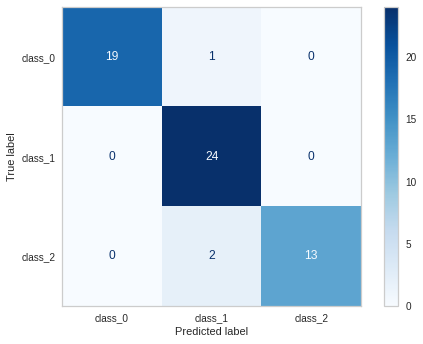

In [60]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(gbrt, X_test, y_test, target_names)

Gradient Boost with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.94
Precision score (0 to 1, ideally should be 1) : 0.95
Recall score (0 to 1, ideally should be 1) : 0.95
F1 score (0 to 1, ideally should be 1) : 0.95
ROC AUC score (0 to 1, ideally should be 1) : 0.99




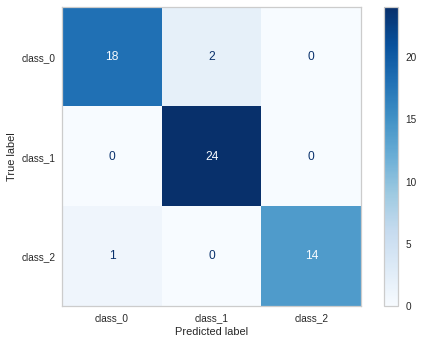

In [61]:
print('Gradient Boost with best fit parameters')
classification_evaluation(y_test, gbrt_best.predict(X_test), gbrt_best.predict_proba(X_test))
display_confusion_matrix(gbrt_best, X_test, y_test, target_names)

### Method V - Random Forest

Random Forest combines random tree models while retaining the predictive power of these models. 

#### Training

In [62]:
# TRAINING

from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators=100, random_state=2) 
forest.fit(X_train, y_train)
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [63]:
param_grid ={'n_estimators': [50, 100, 200],
              'max_depth': [2, 3, 4],
              'max_features': ['sqrt', 'log2', None]}
forest_best = gridSearch(RandomForestClassifier(),param_grid,X_train,y_train)

Best parameters for the model:  {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}
Best Score for the choosen parameters of the model:  0.97


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 1.0




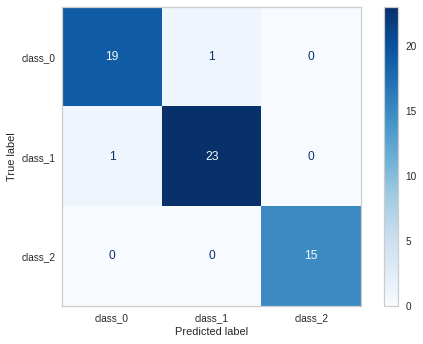

In [64]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(forest, X_test, y_test, target_names)

RandomForest with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.97
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 1.0




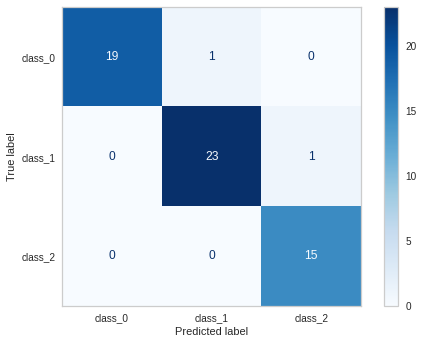

In [65]:
print('RandomForest with best fit parameters')
classification_evaluation(y_test, forest_best.predict(X_test), forest_best.predict_proba(X_test))
display_confusion_matrix(forest_best, X_test, y_test, target_names)

### Method VI - AdaBoost

AdaBoost fits the classifier to the dataset and adjusts the weights of dataset samples in subsequent classifiers on which prior models made prediction errors.

#### Training

In [66]:
# TRAINING

from sklearn.ensemble import AdaBoostClassifier

clf_adb = AdaBoostClassifier(n_estimators=50, random_state=0)
clf_adb.fit(X_train, y_train)
AdaBoostClassifier(n_estimators=50, random_state=0)
y_pred_prob = clf_adb.predict_proba(X_test)
y_pred = clf_adb.predict(X_test)

In [67]:
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0],
              'algorithm': ['SAMME', 'SAMME.R']}
clf_adb_best = gridSearch(AdaBoostClassifier(),param_grid,X_train,y_train)

Best parameters for the model:  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
Best Score for the choosen parameters of the model:  0.95


#### Evaluation


Balanced accuracy score (0 to 1, ideally should be 1) : 0.89
Precision score (0 to 1, ideally should be 1) : 0.9
Recall score (0 to 1, ideally should be 1) : 0.9
F1 score (0 to 1, ideally should be 1) : 0.9
ROC AUC score (0 to 1, ideally should be 1) : 0.94




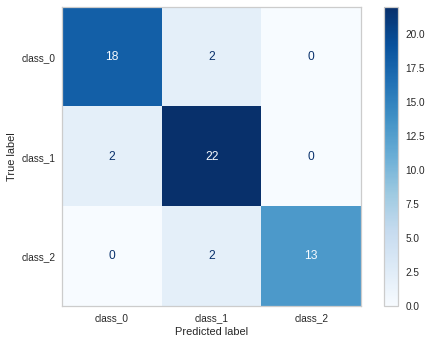

In [68]:
# EVALUATION

classification_evaluation(y_test, y_pred, y_pred_prob)
display_confusion_matrix(clf_adb, X_test, y_test, target_names)

Adaboost with best fit parameters

Balanced accuracy score (0 to 1, ideally should be 1) : 0.96
Precision score (0 to 1, ideally should be 1) : 0.97
Recall score (0 to 1, ideally should be 1) : 0.97
F1 score (0 to 1, ideally should be 1) : 0.97
ROC AUC score (0 to 1, ideally should be 1) : 0.99




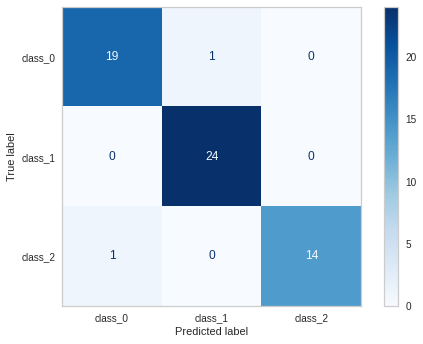

In [69]:
print('Adaboost with best fit parameters')
classification_evaluation(y_test, clf_adb_best.predict(X_test), clf_adb_best.predict_proba(X_test))
display_confusion_matrix(clf_adb_best, X_test, y_test, target_names)

### ROC curve Comparison for Split Data Protocol

ROC curve is ideally used for binary classification. For mutliclass classification, tpr and tpr are calculated after binarizing the classes. Here, OneVsRest classification is used to plot the ROC curve, which compares one class against rest of the classes.[\[6\]](#reference_6)

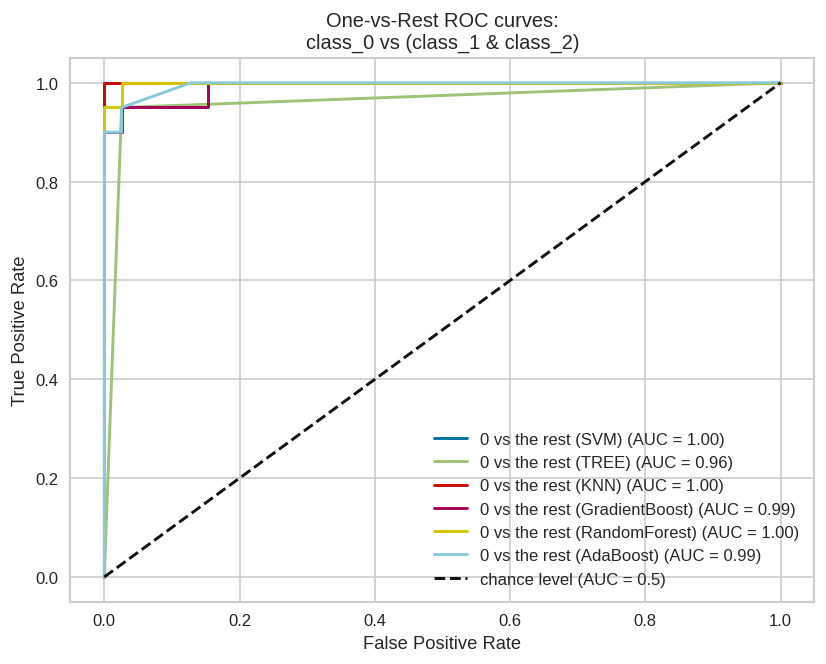

In [70]:
# class_0 vs REST ROC Comparison for all Split Data Protocol Methods

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

y_score = clf_svm_best.predict_proba(X_test)
svm_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (SVM)",
                                            ax=ax)

y_score = tree_best.predict_proba(X_test)
tree_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (TREE)",
                                            ax=ax)

y_score = knn_best.predict_proba(X_test)
knn_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (KNN)",
                                            ax=ax)

y_score = gbrt_best.predict_proba(X_test)
gbrt_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (GradientBoost)",
                                            ax=ax)

y_score = forest_best.predict_proba(X_test)
forest_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (RandomForest)",
                                            ax=ax)

y_score = clf_adb_best.predict_proba(X_test)
clf_adb_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (AdaBoost)",
                                            ax=ax)


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nclass_0 vs (class_1 & class_2)")
plt.legend()
plt.show()

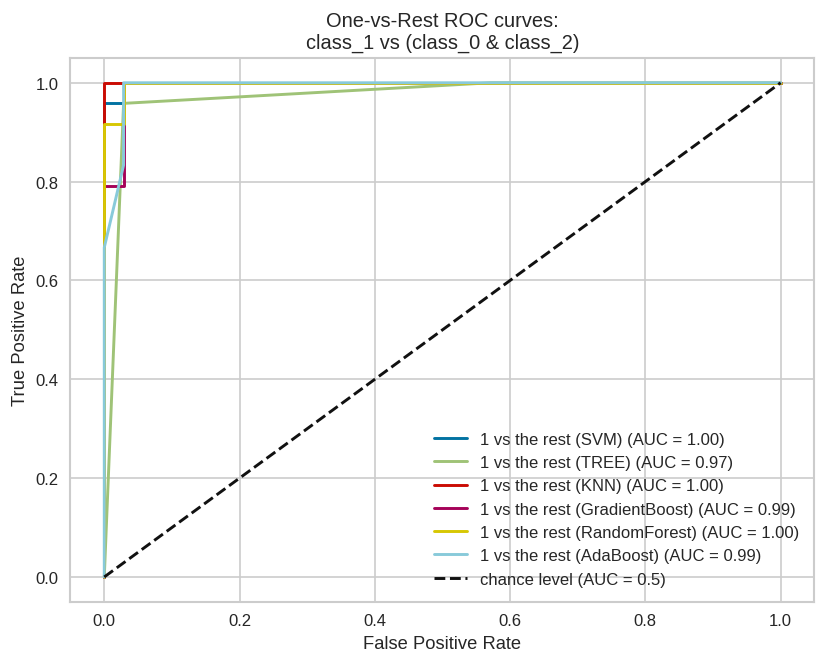

In [71]:
# class_1 vs REST ROC Comparison for all Split Data Protocol Methods

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = 1
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

y_score = clf_svm_best.predict_proba(X_test)
svm_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (SVM)",
                                            ax=ax)

y_score = tree_best.predict_proba(X_test)
tree_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (TREE)",
                                            ax=ax)

y_score = knn_best.predict_proba(X_test)
knn_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (KNN)",
                                            ax=ax)

y_score = gbrt_best.predict_proba(X_test)
gbrt_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (GradientBoost)",
                                            ax=ax)

y_score = forest_best.predict_proba(X_test)
forest_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (RandomForest)",
                                            ax=ax)

y_score = clf_adb_best.predict_proba(X_test)
clf_adb_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (AdaBoost)",
                                            ax=ax)


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nclass_1 vs (class_0 & class_2)")
plt.legend()
plt.show()

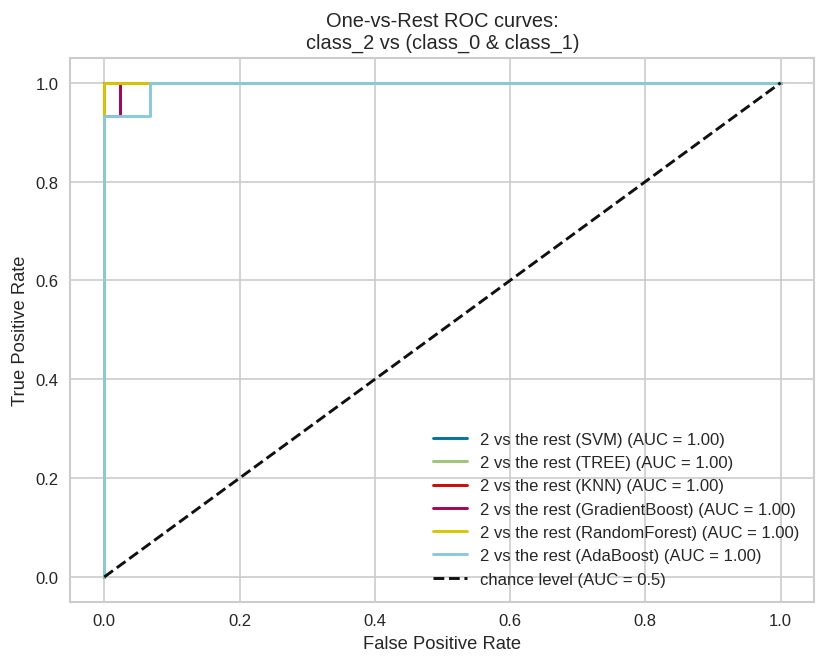

In [72]:
# class_2 vs REST ROC Comparison for all Split Data Protocol Methods

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

y_score = clf_svm_best.predict_proba(X_test)
svm_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (SVM)",
                                            ax=ax)

y_score = tree_best.predict_proba(X_test)
tree_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (TREE)",
                                            ax=ax)

y_score = knn_best.predict_proba(X_test)
knn_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (KNN)",
                                            ax=ax)

y_score = gbrt_best.predict_proba(X_test)
gbrt_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (GradientBoost)",
                                            ax=ax)

y_score = forest_best.predict_proba(X_test)
forest_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (RandomForest)",
                                            ax=ax)

y_score = clf_adb_best.predict_proba(X_test)
clf_adb_disp = RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                            y_score[:, class_id],
                                            name=f"{class_of_interest} vs the rest (AdaBoost)",
                                            ax=ax)


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nclass_2 vs (class_0 & class_1)")
plt.legend()
plt.show()

## K-Fold Cross Validation

K-fold cross validation allows to measure the performance of a model by assessing 'k' different models which are trained on k-1 splits of the dataset, and evaluated on the remaining data in the respective folds. 

K-fold cross-validation for K=8.

In [73]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

def kfold_cross_validation(clf, X, y, target_names):
    scores = []

    for k, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X[train], y[train])
        score = clf.score(X[test], y[test])
        y_pred = clf.predict(X[test])
        y_pred_prob = clf.predict_proba(X[test])
        scores.append(score)
        print(f"\nFOLD {k+1} :")
        print(f"\tScore = {score}")
        print(f"\tBalanced accuracy score (0 to 1, ideally should be 1) = {balanced_accuracy_score(y[test], y_pred)}")
        print(f"\tPrecision score (0 to 1, ideally should be 1) = {precision_score(y[test], y_pred, average='micro')}")
        print(f"\tRecall score (0 to 1, ideally should be 1) = {recall_score(y[test], y_pred, average='micro')}")
        print(f"\tF1 score (0 to 1, ideally should be 1) = {f1_score(y[test], y_pred, average='micro')}")
        print(f"\tROC AUC score (0 to 1, ideally should be 1) = {roc_auc_score(y[test], y_pred_prob, multi_class='ovr')}")
        print("\n")
        display_confusion_matrix(clf, X[test], y[test], target_names)
        if k == 7:
            print(f"\nMean K-Fold score = {np.mean(scores)}, Standard deviation in score = {np.std(scores)}")
        

### Method I - SVM


FOLD 1 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




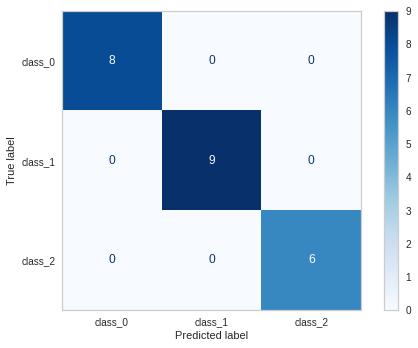


FOLD 2 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9973544973544973




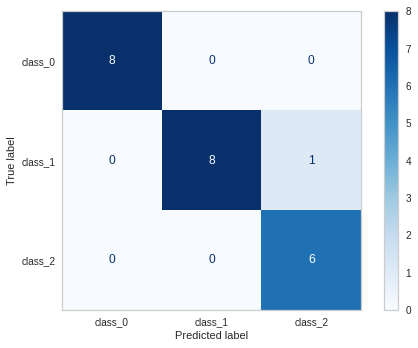


FOLD 3 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9583333333333334
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




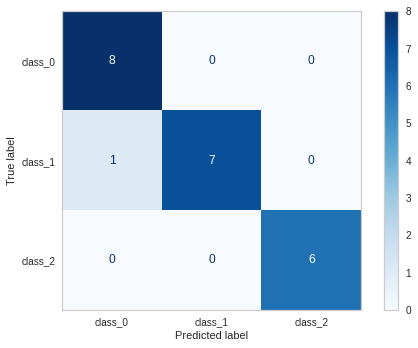


FOLD 4 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9444444444444445
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




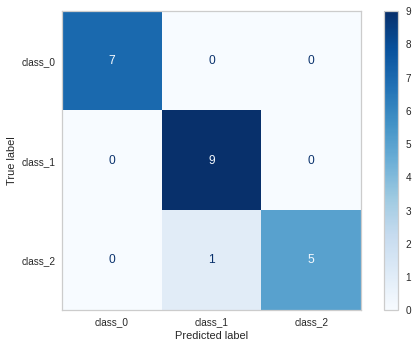


FOLD 5 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




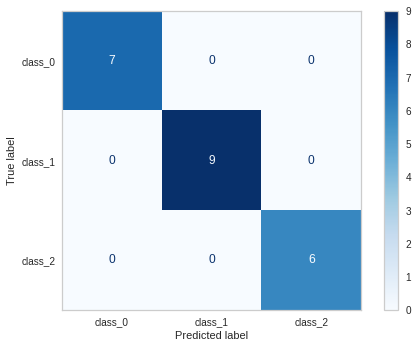


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




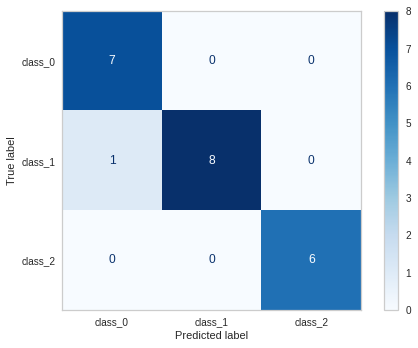


FOLD 7 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




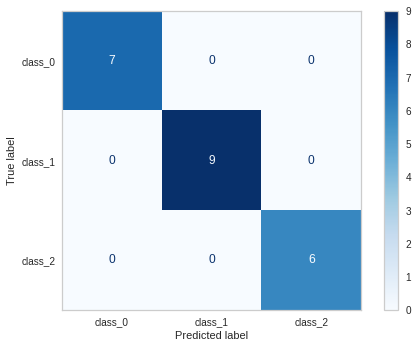


FOLD 8 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




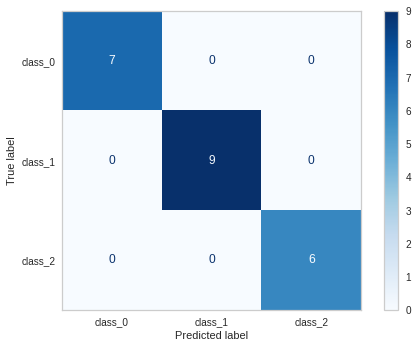


Mean K-Fold score = 0.9775197628458498, Standard deviation in score = 0.02248837970937795


In [74]:
# TRAINING and EVALUATION

from sklearn import svm

clf = svm.SVC(C= 100, gamma= 0.001, kernel= 'rbf', probability=True)
kfold_cross_validation(clf, X_pca, y, target_names)

### Method II - Decision Trees


FOLD 1 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9783068783068783




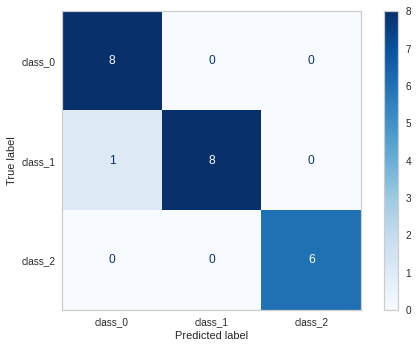


FOLD 2 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9610955493308434




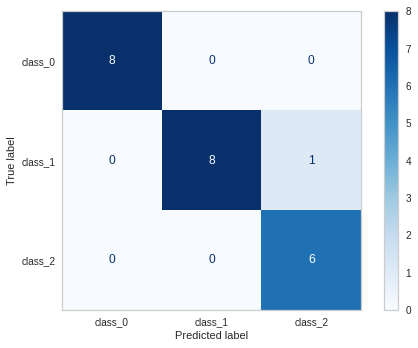


FOLD 3 :
	Score = 0.9090909090909091
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9166666666666666
	Precision score (0 to 1, ideally should be 1) = 0.9090909090909091
	Recall score (0 to 1, ideally should be 1) = 0.9090909090909091
	F1 score (0 to 1, ideally should be 1) = 0.9090909090909091
	ROC AUC score (0 to 1, ideally should be 1) = 0.9523809523809524




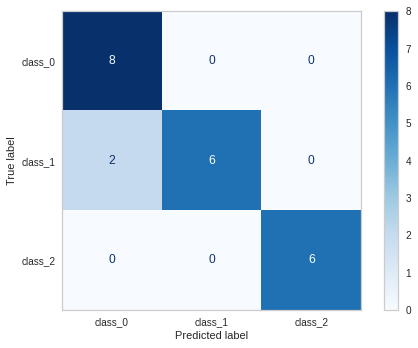


FOLD 4 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9523809523809524
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9633699633699634




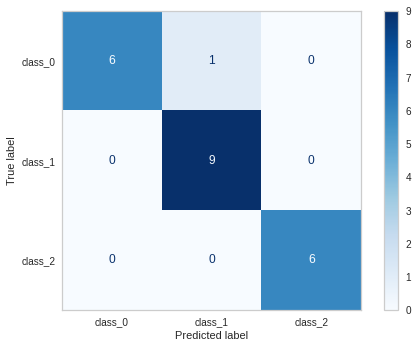


FOLD 5 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




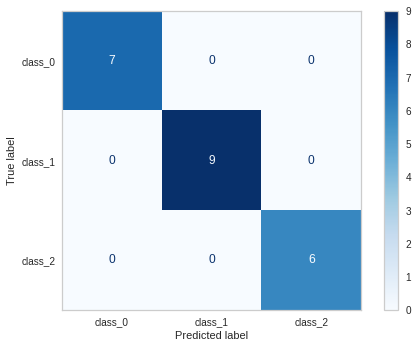


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.978917378917379




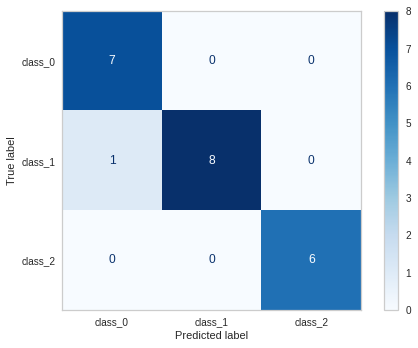


FOLD 7 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.978917378917379




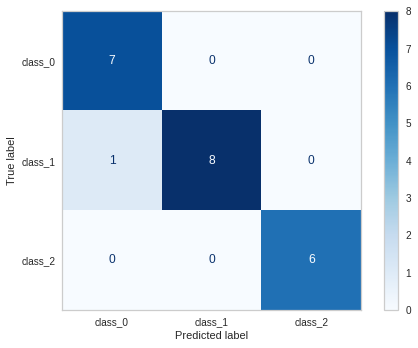


FOLD 8 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9523809523809524
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9619047619047619




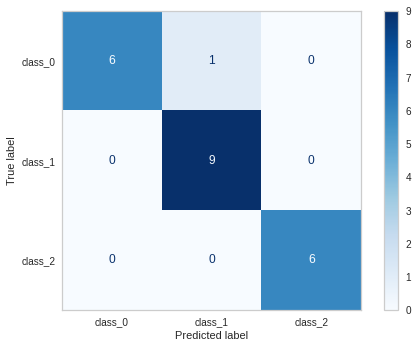


Mean K-Fold score = 0.9550395256916997, Standard deviation in score = 0.02274337803652946


In [75]:
# TRAINING and EVALUATION

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 2, min_samples_split= 2, splitter= 'best',random_state=0)
kfold_cross_validation(tree, X_pca, y, target_names)

### Method III - KNN


FOLD 1 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




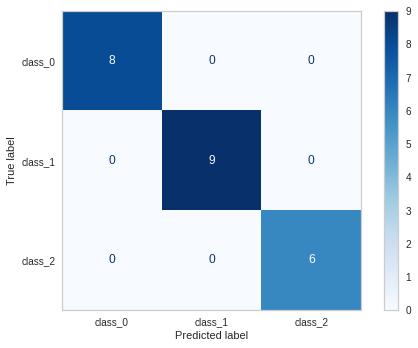


FOLD 2 :
	Score = 0.9130434782608695
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9259259259259259
	Precision score (0 to 1, ideally should be 1) = 0.9130434782608695
	Recall score (0 to 1, ideally should be 1) = 0.9130434782608695
	F1 score (0 to 1, ideally should be 1) = 0.9130434782608695
	ROC AUC score (0 to 1, ideally should be 1) = 0.9946428571428573




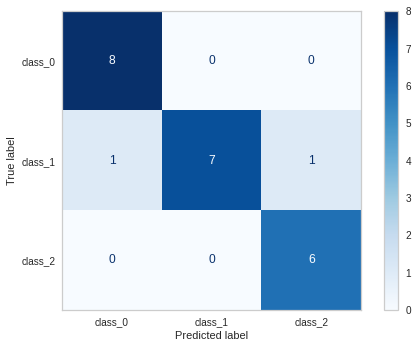


FOLD 3 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9583333333333334
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




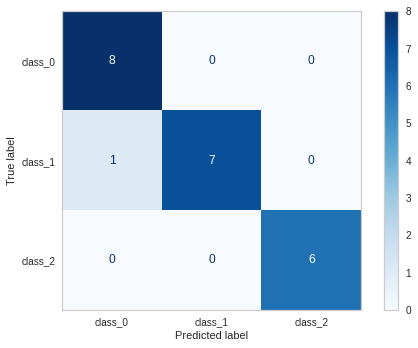


FOLD 4 :
	Score = 0.9090909090909091
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9074074074074074
	Precision score (0 to 1, ideally should be 1) = 0.9090909090909091
	Recall score (0 to 1, ideally should be 1) = 0.9090909090909091
	F1 score (0 to 1, ideally should be 1) = 0.9090909090909091
	ROC AUC score (0 to 1, ideally should be 1) = 0.9941391941391942




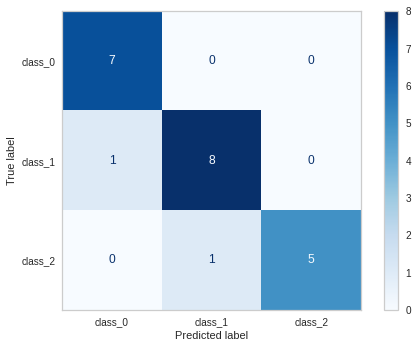


FOLD 5 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




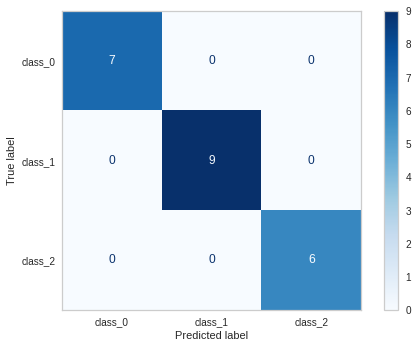


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9703703703703703




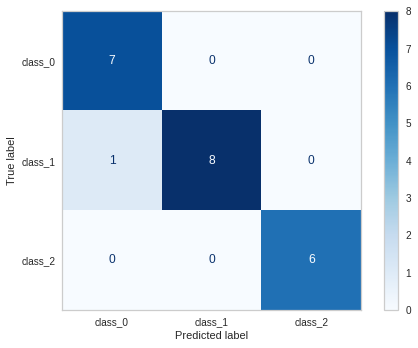


FOLD 7 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.995414886039886




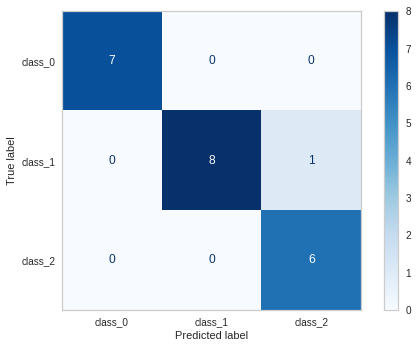


FOLD 8 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




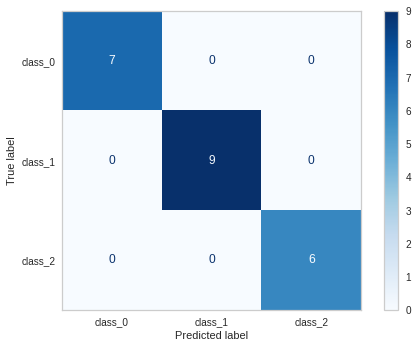


Mean K-Fold score = 0.9607213438735178, Standard deviation in score = 0.03478818760280516


In [76]:
# TRAINING and EVALUATION

from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(algorithm= 'auto', metric= 'euclidean', n_neighbors= 5, weights= 'uniform')
kfold_cross_validation(knn, X_pca, y, target_names)

### Method IV - Gradient Boost


FOLD 1 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9729497354497355




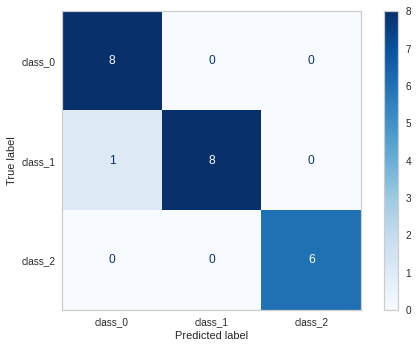


FOLD 2 :
	Score = 0.9130434782608695
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9212962962962963
	Precision score (0 to 1, ideally should be 1) = 0.9130434782608695
	Recall score (0 to 1, ideally should be 1) = 0.9130434782608695
	F1 score (0 to 1, ideally should be 1) = 0.9130434782608695
	ROC AUC score (0 to 1, ideally should be 1) = 0.9699657640834111




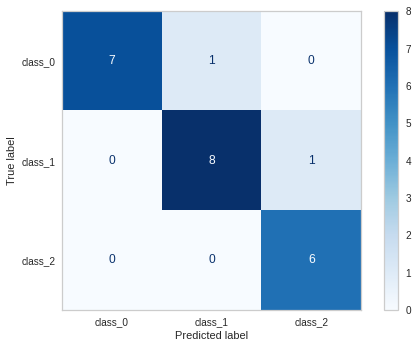


FOLD 3 :
	Score = 0.8636363636363636
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.8611111111111112
	Precision score (0 to 1, ideally should be 1) = 0.8636363636363636
	Recall score (0 to 1, ideally should be 1) = 0.8636363636363636
	F1 score (0 to 1, ideally should be 1) = 0.8636363636363636
	ROC AUC score (0 to 1, ideally should be 1) = 0.9880952380952381




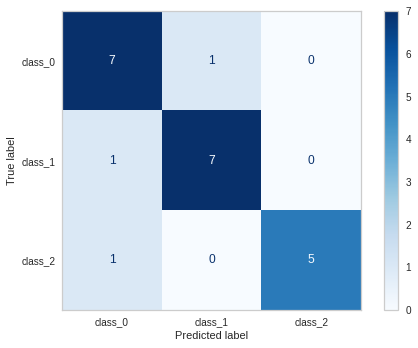


FOLD 4 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9523809523809524
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9851037851037852




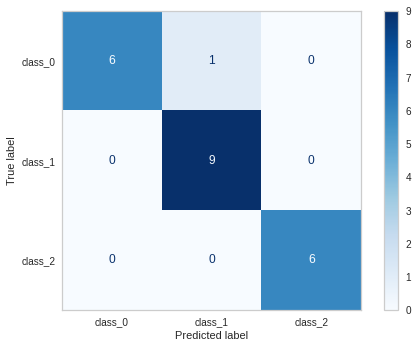


FOLD 5 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9444444444444445
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




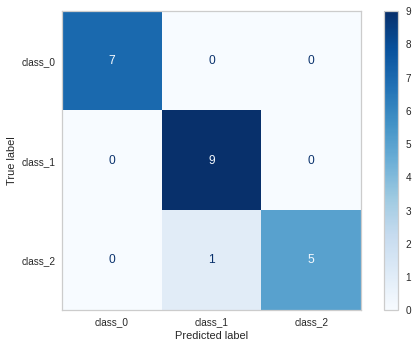


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.964021164021164




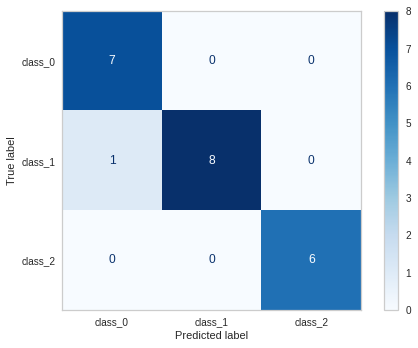


FOLD 7 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




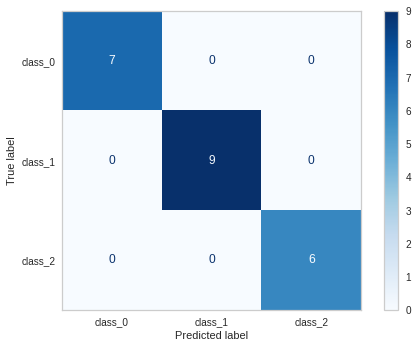


FOLD 8 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




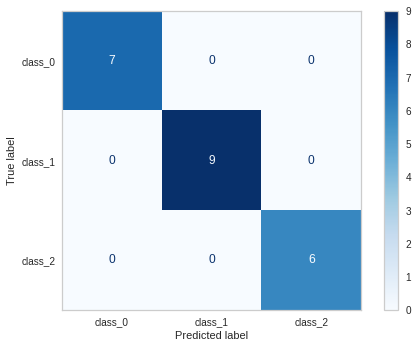


Mean K-Fold score = 0.9496047430830039, Standard deviation in score = 0.0417248860290858


In [77]:
# TRAINING and EVALUATION

from sklearn.ensemble import GradientBoostingClassifier 

gbrt = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 1, n_estimators= 200,random_state=0) 
kfold_cross_validation(gbrt, X_pca, y, target_names)

### Method V - Random Forest




FOLD 1 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




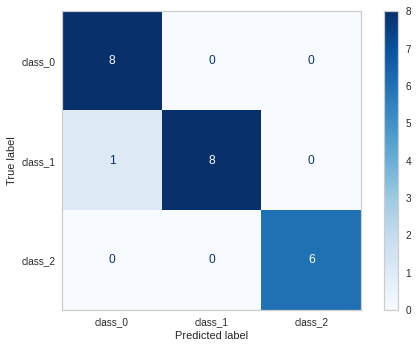


FOLD 2 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9702769996887644




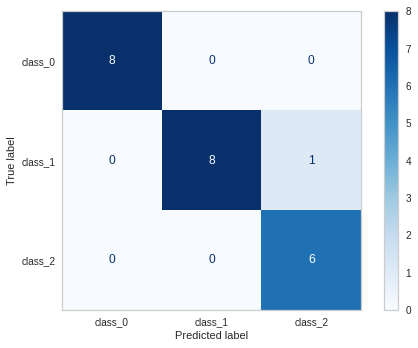


FOLD 3 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9583333333333334
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9970238095238096




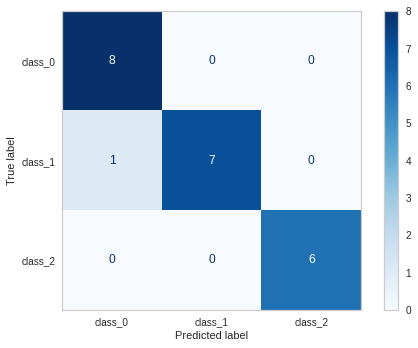


FOLD 4 :
	Score = 0.9090909090909091
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.8968253968253969
	Precision score (0 to 1, ideally should be 1) = 0.9090909090909091
	Recall score (0 to 1, ideally should be 1) = 0.9090909090909091
	F1 score (0 to 1, ideally should be 1) = 0.9090909090909091
	ROC AUC score (0 to 1, ideally should be 1) = 0.9968253968253968




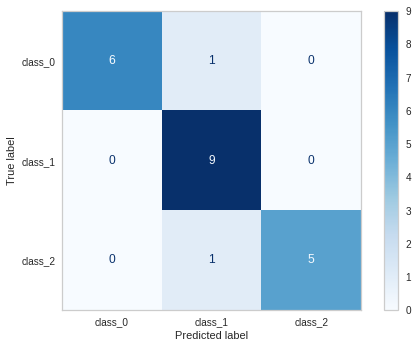


FOLD 5 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




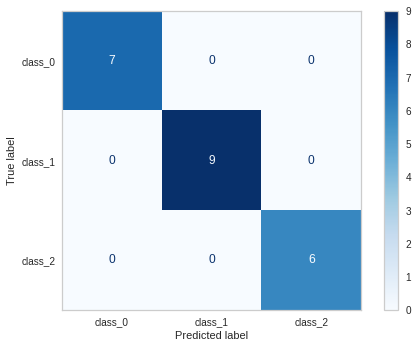


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9971509971509972




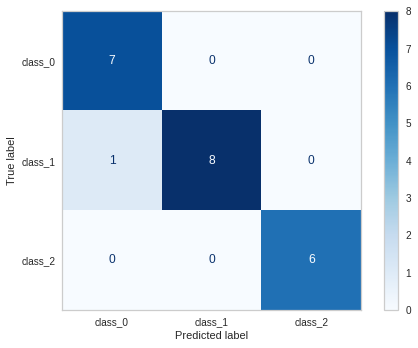


FOLD 7 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




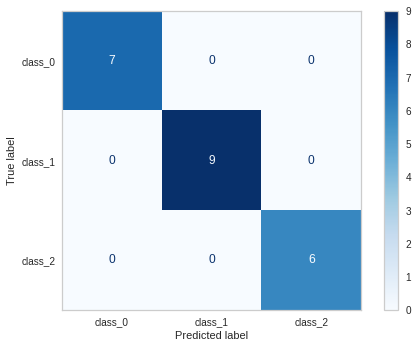


FOLD 8 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




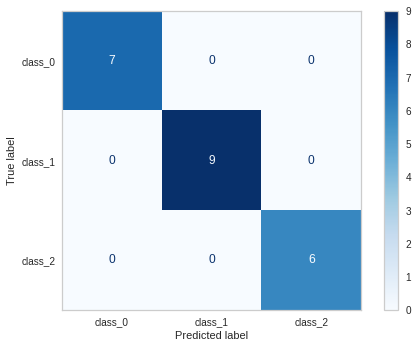


Mean K-Fold score = 0.9664031620553359, Standard deviation in score = 0.029890283522241448


In [78]:
# TRAINING and EVALUATION

from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(max_depth= 3, max_features= 'sqrt', n_estimators= 50, random_state=2) 
kfold_cross_validation(forest, X_pca, y, target_names)

### Method VI - AdaBoost


FOLD 1 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.991931216931217




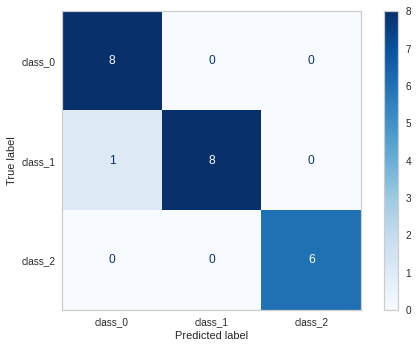


FOLD 2 :
	Score = 0.9565217391304348
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9565217391304348
	Recall score (0 to 1, ideally should be 1) = 0.9565217391304348
	F1 score (0 to 1, ideally should be 1) = 0.9565217391304348
	ROC AUC score (0 to 1, ideally should be 1) = 0.9911297852474323




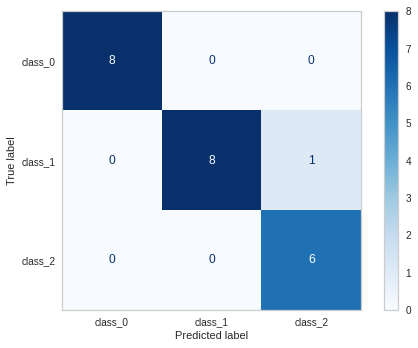


FOLD 3 :
	Score = 0.9090909090909091
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9027777777777778
	Precision score (0 to 1, ideally should be 1) = 0.9090909090909091
	Recall score (0 to 1, ideally should be 1) = 0.9090909090909091
	F1 score (0 to 1, ideally should be 1) = 0.9090909090909091
	ROC AUC score (0 to 1, ideally should be 1) = 0.9846230158730158




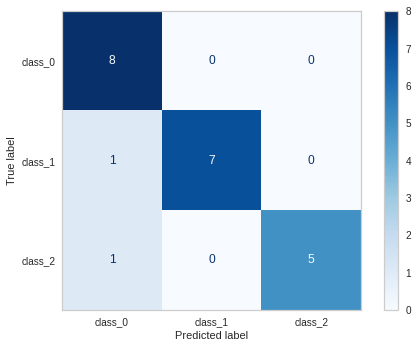


FOLD 4 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9523809523809524
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.9820919820919821




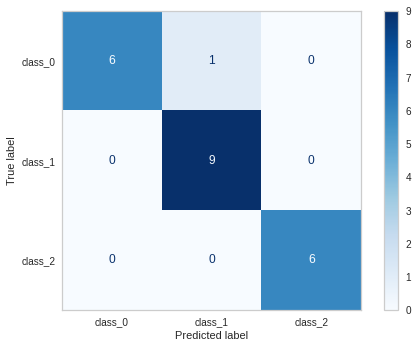


FOLD 5 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9444444444444445
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




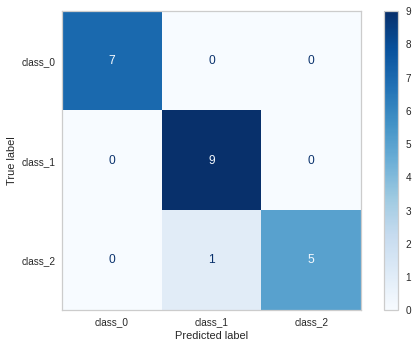


FOLD 6 :
	Score = 0.9545454545454546
	Balanced accuracy score (0 to 1, ideally should be 1) = 0.9629629629629629
	Precision score (0 to 1, ideally should be 1) = 0.9545454545454546
	Recall score (0 to 1, ideally should be 1) = 0.9545454545454546
	F1 score (0 to 1, ideally should be 1) = 0.9545454545454546
	ROC AUC score (0 to 1, ideally should be 1) = 0.96988196988197




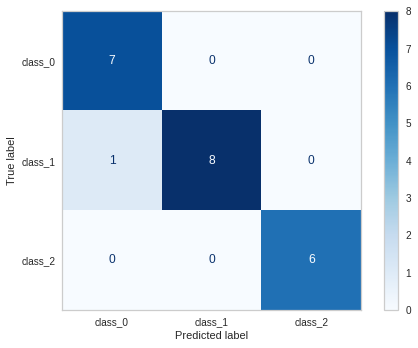


FOLD 7 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




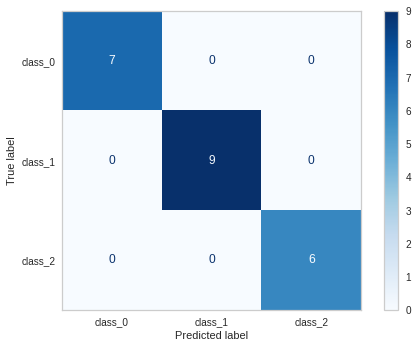


FOLD 8 :
	Score = 1.0
	Balanced accuracy score (0 to 1, ideally should be 1) = 1.0
	Precision score (0 to 1, ideally should be 1) = 1.0
	Recall score (0 to 1, ideally should be 1) = 1.0
	F1 score (0 to 1, ideally should be 1) = 1.0
	ROC AUC score (0 to 1, ideally should be 1) = 1.0




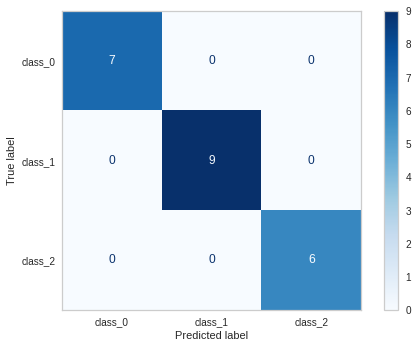


Mean K-Fold score = 0.9607213438735178, Standard deviation in score = 0.027159311563945698


In [79]:
# TRAINING and EVALUATION

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 0.1, n_estimators= 100, random_state=0)
kfold_cross_validation(clf, X_pca, y, target_names)

### ROC Curve Comparision for K-Fold

OneVsRestClassifier is used to classify one class from the rest for different classifiers.'cross_val_predict' returns the mean auc score of all K-Folds. Using this score, fpr and tpr are calculated and ROC curve is plotted for each class vs rest.[\[8\]](#reference_8)

In [80]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict

def getROCScoresCV(clf, X, y, classes, cv):
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]
    
    ovr_clf = OneVsRestClassifier(clf)
    y_score = cross_val_predict(ovr_clf, X, y, cv=cv, method='predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return fpr,tpr,roc_auc

def getROCScoresCVTree(clf, X, y, classes, cv):
    y_bin = label_binarize(y, classes=classes)
    n_classes = y_bin.shape[1]
    
    y_score = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return fpr,tpr,roc_auc

In [81]:
# Calculating the average scores for KFold methods

fpr_svm, tpr_svm, roc_auc_svm = getROCScoresCV(svm.SVC(probability=True),X_pca,y,[0,1,2],8)

fpr_dt, tpr_dt, roc_auc_dt = getROCScoresCVTree(DecisionTreeClassifier(),X_pca,y,[0,1,2],8)

fpr_knn, tpr_knn, roc_auc_knn = getROCScoresCV(KNeighborsClassifier(),X_pca,y,[0,1,2],8)

fpr_gbrt, tpr_gbrt, roc_auc_gbrt = getROCScoresCV(GradientBoostingClassifier(),X_pca,y,[0,1,2],8)

fpr_rf, tpr_rf, roc_auc_rf = getROCScoresCV(RandomForestClassifier(),X_pca,y,[0,1,2],8)

fpr_ada, tpr_ada, roc_auc_ada = getROCScoresCV(AdaBoostClassifier(),X_pca,y,[0,1,2],8)

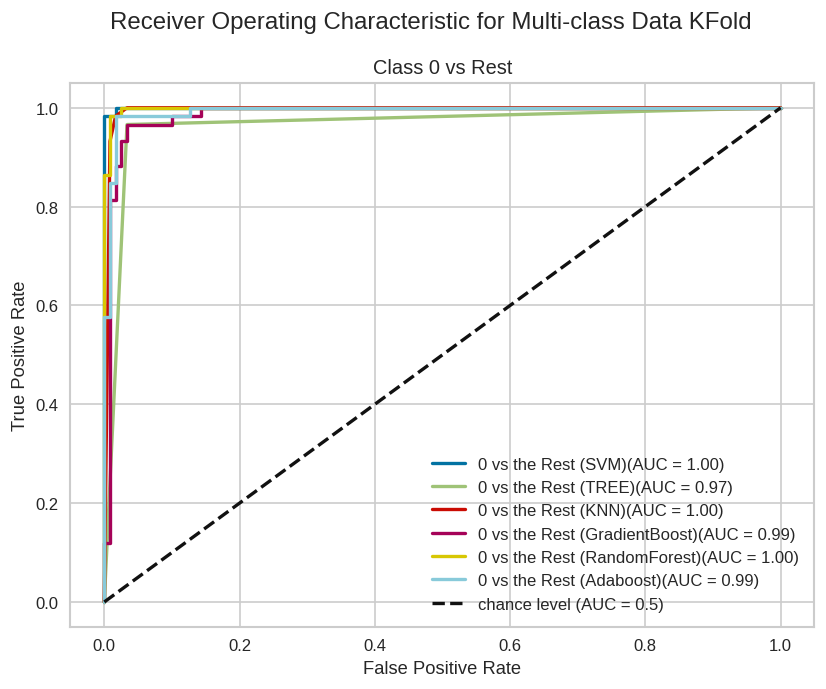

In [82]:
# class_0 vs REST ROC Comparison for all K-Fold Methods

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

plt.plot(fpr_svm[0], tpr_svm[0], lw=2,
             label='{0} vs the Rest (SVM)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_svm[0]))

plt.plot(fpr_dt[0], tpr_dt[0], lw=2,
             label='{0} vs the Rest (TREE)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_dt[0]))

plt.plot(fpr_knn[0], tpr_knn[0], lw=2,
             label='{0} vs the Rest (KNN)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_knn[0]))

plt.plot(fpr_gbrt[0], tpr_gbrt[0], lw=2,
             label='{0} vs the Rest (GradientBoost)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_gbrt[0]))

plt.plot(fpr_rf[0], tpr_rf[0], lw=2,
             label='{0} vs the Rest (RandomForest)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_rf[0]))

plt.plot(fpr_ada[0], tpr_ada[0], lw=2,
             label='{0} vs the Rest (Adaboost)(AUC = {1:0.2f})'
             ''.format(0, roc_auc_ada[0]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="chance level (AUC = 0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('Receiver Operating Characteristic for Multi-class Data KFold')
plt.title('Class 0 vs Rest')
plt.legend(loc="lower right")
plt.show()

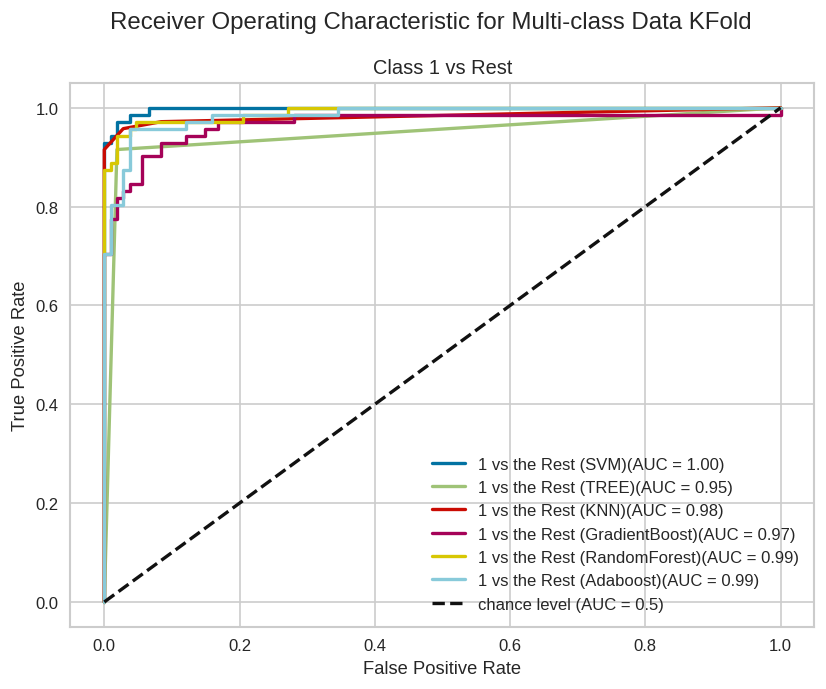

In [83]:
# class_1 vs REST ROC Comparison for all K-Fold Methods

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

plt.plot(fpr_svm[1], tpr_svm[1], lw=2,
             label='{0} vs the Rest (SVM)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_svm[1]))

plt.plot(fpr_dt[1], tpr_dt[1], lw=2,
             label='{0} vs the Rest (TREE)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_dt[1]))

plt.plot(fpr_knn[1], tpr_knn[1], lw=2,
             label='{0} vs the Rest (KNN)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_knn[1]))

plt.plot(fpr_gbrt[1], tpr_gbrt[1], lw=2,
             label='{0} vs the Rest (GradientBoost)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_gbrt[1]))

plt.plot(fpr_rf[1], tpr_rf[1], lw=2,
             label='{0} vs the Rest (RandomForest)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_rf[1]))

plt.plot(fpr_ada[1], tpr_ada[1], lw=2,
             label='{0} vs the Rest (Adaboost)(AUC = {1:0.2f})'
             ''.format(1, roc_auc_ada[1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="chance level (AUC = 0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('Receiver Operating Characteristic for Multi-class Data KFold')
plt.title('Class 1 vs Rest')
plt.legend(loc="lower right")
plt.show()

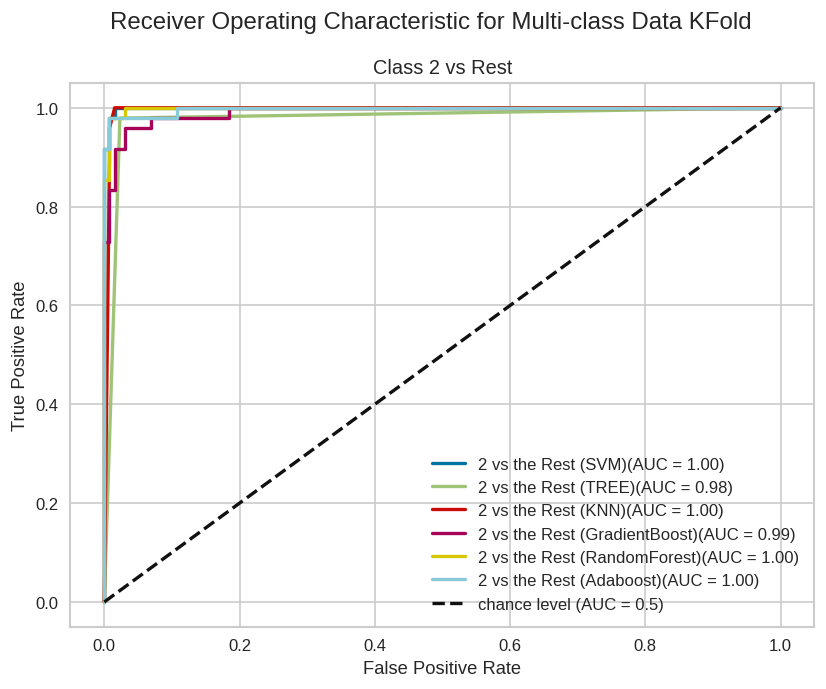

In [84]:
# class_2 vs REST ROC Comparison for all K-Fold Methods

fig, ax = plt.subplots(figsize = (8, 6), dpi=120)

plt.plot(fpr_svm[2], tpr_svm[2], lw=2,
             label='{0} vs the Rest (SVM)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_svm[2]))

plt.plot(fpr_dt[2], tpr_dt[2], lw=2,
             label='{0} vs the Rest (TREE)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_dt[2]))

plt.plot(fpr_knn[2], tpr_knn[2], lw=2,
             label='{0} vs the Rest (KNN)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_knn[2]))

plt.plot(fpr_gbrt[2], tpr_gbrt[2], lw=2,
             label='{0} vs the Rest (GradientBoost)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_gbrt[2]))

plt.plot(fpr_rf[2], tpr_rf[2], lw=2,
             label='{0} vs the Rest (RandomForest)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_rf[2]))

plt.plot(fpr_ada[2], tpr_ada[2], lw=2,
             label='{0} vs the Rest (Adaboost)(AUC = {1:0.2f})'
             ''.format(2, roc_auc_ada[2]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="chance level (AUC = 0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('Receiver Operating Characteristic for Multi-class Data KFold')
plt.title('Class 2 vs Rest')
plt.legend(loc="lower right")
plt.show()

# References

<a id='reference_1'></a>
\[1\] A. Tomar, “Stop using elbow method in k-means clustering, instead, use this!,” Medium, 29-Nov-2022. [Online]. Available: https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d. [Accessed: 21-Feb-2023]. 

<a id='reference_2'></a>
\[2\] “2.3. clustering,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/clustering.html#dbscan. [Accessed: 21-Feb-2023].

<a id='reference_3'></a>
\[3\] “Sklearn.cluster.DBSCAN,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html. [Accessed: 21-Feb-2023].

<a id='reference_4'></a>
\[4\] “Sklearn.cluster.AffinityPropagation,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html. [Accessed: 21-Feb-2023].

<a id='reference_5'></a>
\[5\] “Sklearn.cluster.birch,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch. [Accessed: 21-Feb-2023].

<a id='reference_6'></a>
\[6\] “Multiclass receiver operating characteristic (ROC),” scikit. [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html. [Accessed: 21-Feb-2023].

<a id='reference_7'></a>
\[7\] “Sklearn.ensemble.gradientboostingclassifier,” scikit. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html. [Accessed: 21-Feb-2023].

<a id='reference_8'></a>
\[8\] Meng Shen and seralouk, “How to compute average roc for cross validated for multiclass,” Stack Overflow, 19-Jul-2018. [Online]. Available: https://stackoverflow.com/questions/47876999/how-to-compute-average-roc-for-cross-validated-for-multiclass/51425049#51425049. [Accessed: 21-Feb-2023].

<a id='reference_9'></a>
\[9\] Sarah. Müller, Andreas C. ; Guido, Introduction to machine learning with python: A guide for data scientists. Sebastopol: O'Reilly Media, 2016.